# 프로젝트: 뉴스기사 요약해보기

## 루브릭
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. 데이터 준비하기

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.sample(10)

,headlines,text
65598,Amazon rumour led to record high surge in Bitc...,A rumour which citied that Amazon will start a...
59620,English fans target David Warner's wife in new...,"Barmy Army, a group of English cricket fans, t..."
2649,"Met Sangeeta in ad shoot in 1985, it was love ...","Ex-India captain Mohammed Azharuddin, while ta..."
54555,Have requested FM to bring jet fuel under GST:...,Union Minister Jayant Sinha on Thursday said t...
39122,"I was Nolan's 1st choice for The Joker, jokes ...","Janhvi Kapoor, in an Instagram story, shared a..."
2081,"Cow stuck on Alaknanda river bank, saved post ...",A cow was stuck on the bank of Alaknanda river...
76094,Delhi to see fastest growth in Asia in 5 yrs:...,Delhi will have the fastest growth among Asian...
89883,Bieber is role model for millennial generation...,Sarod maestro Ustad Amjad Ali Khan has said th...
59082,Kohli's U-19 teammate Siddarth Kaul gets India...,"Siddarth Kaul, Indian captain Virat Kohli's fo..."
48924,"After losing 8 wickets to spinners, SA train w...",South African batsmen trained with five wrist ...


* 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습 
* 추출적 요약을 하는 경우에는 오직 text열만을 사용

## NLTK에서 불용어 수집하기

In [4]:
# 불용어 다운로드
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

불용어는 자주 등장하지만 분석을 하는 데 큰 도움이 되지 않는 단어들을 이야기 한다.    
개인적으로 이 프로젝트에서 부정적인 표현은 요약을 할 때 도움이 된다고 생각해 
두 경우의 stopwords에 대해서 성능 비교를 할 예정이다.

In [5]:
# 불용어 확인하기
from nltk.corpus import stopwords
ALL_STOPWORDS = stopwords.words('english')

delete_stopwords=['no', 'nor','not']
MY_STOPWORDS = [word for word in stopwords.words('english') if word not in delete_stopwords]

print(f'original stopwords:{len(ALL_STOPWORDS)}, my stopwords:{len(MY_STOPWORDS)}')

original stopwords:179, my stopwords:176


# 2. 데이터 전처리하기

https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python    
전처리하기 전 정규화 사전을 정의하고 정규화를 진행한다.

In [6]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


### 중복값과 null값 제거

In [7]:
print(f'Text열 중복되지 않는 샘플 수: {data["text"].nunique()}')
print(f'headlines열 중복되지 않는 샘플 수: {data["headlines"].nunique()}')

Text열 중복되지 않는 샘플 수: 98360
headlines열 중복되지 않는 샘플 수: 98280


In [8]:
print(f'Text열 중복되지 않는 샘플 비율: {data["text"].nunique()/len(data)}')
print(f'headlines열 중복되지 않는 샘플 비율: {data["headlines"].nunique()/len(data)}')

Text열 중복되지 않는 샘플 비율: 0.9995833375677077
headlines열 중복되지 않는 샘플 비율: 0.9987703376998202


중복되지 않는 샘플의 수가 99%로 높은 편이지만 중복되는 샘플도 존재하기는 하므로 삭제해준다. 단, headlines는 text를 요약한 것이므로 중복하는 경우도 발생한다. 따라서 text에 중복되는 샘플만 삭제한다.

In [9]:
print(f'before: {len(data)}')
data.drop_duplicates(subset=['text'], inplace=True)
print(f'after: {len(data)}')

before: 98401
after: 98360


In [10]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

null값은 존재하지 않는다.

In [11]:
data.iloc[0]

headlines    upGrad learner switches to career in ML & Al w...
text         Saurav Kant, an alumnus of upGrad and IIIT-B's...
Name: 0, dtype: object

### 전처리 함수 정의하기

실습에서는 BeautifulSoup으로 html tag를 제거했는데 데이터를 살펴본 결과 html tag가 안보인다. 그럼에도 삭제를 하는 이유가 무엇일까? BeautifulSoup을 사용할 때와 사용하지 않을 때를 비교하기 위해 파라미터를 추가했다.

In [12]:
from bs4 import BeautifulSoup
def preprocess_sentence(sentence, use_beautifulsoup=True, remove_stopwords=True, stopwords_list=None):
    sentence = sentence.lower() # 텍스트 소문자화
    
    if use_beautifulsoup:
        sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub('[a-zA-Z](.)\1{2,}', '', sentence) # 같은 문자가 3개 이상이면 삭제
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환    
    
    
    # 불용어 제거
    if remove_stopwords:
        tokens= ' '.join(word for word in sentence.split() if not word in stopwords_list if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
        
    return tokens


In [13]:
# 전처리 함수가 잘 만들어졌는지 확인
temp_text="With Aegon Life iTerm Insurance plan, customers can not enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years."
temp_headline = "New Zealand end Rohit Sharma-led India's 12-match winning streak"

print('text: ',temp_text)
print('headline: ', temp_headline)
print('****')
print("original stopwords")
print(preprocess_sentence(temp_text, stopwords_list=ALL_STOPWORDS))
print(preprocess_sentence(temp_headline, remove_stopwords=False, stopwords_list=ALL_STOPWORDS))

print("my stopwords")
print(preprocess_sentence(temp_text, stopwords_list=MY_STOPWORDS))
print(preprocess_sentence(temp_headline, remove_stopwords=False, stopwords_list=MY_STOPWORDS))

text:  With Aegon Life iTerm Insurance plan, customers can not enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.
headline:  New Zealand end Rohit Sharma-led India's 12-match winning streak
****
original stopwords
aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental death benefit rider life cover age years
new zealand end rohit sharma led india match winning streak
my stopwords
aegon life iterm insurance plan customers not enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental death benefit rider life cover age years

headline이 경우 불용어를 제거하지 않는다.

### MultiProcessing을 이용한 데이터셋 전처리

In [14]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences,  use_beautifulsoup, remove_stopwords, stopwords_list):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, use_beautifulsoup, remove_stopwords, stopwords_list),
    return texts

def preprocess_data(data, use_beautifulsoup=True, remove_stopwords=True, stopwords_list=None):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, use_beautifulsoup=use_beautifulsoup, remove_stopwords=remove_stopwords, stopwords_list=stopwords_list), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print(time.time() - start_time, " seconds")
    return processed_data

def get_data_after_preprocess(df, use_beautifulsoup=True, stopwords_list=None):
    df_temp = df.copy()
    df_temp['text'] = preprocess_data(data['text'], use_beautifulsoup=use_beautifulsoup, stopwords_list=stopwords_list)
    df_temp['headlines'] = preprocess_data(data['headlines'], use_beautifulsoup=use_beautifulsoup, remove_stopwords=False, stopwords_list=stopwords_list)
    
    # 전처리 후 빈 값이 생길 수 있다. 빈값인 경우 Null로 변환
    df_temp.replace('', np.nan, inplace=True)
    
    # null이 있을 경우 null값 삭제
    if data.isnull().sum().sum() != 0:
        df_temp.dropna(axis=0, inplace=True)
    
    print('전체 샘플 수: ', len(df_temp))
    return df_temp

In [529]:
data_all_stopwords = get_data_after_preprocess(data, stopwords_list=ALL_STOPWORDS)
data_my_stopwords = get_data_after_preprocess(data, stopwords_list=MY_STOPWORDS)
data_donuse_beautifulsoup = get_data_after_preprocess(data, use_beautifulsoup=False, stopwords_list=ALL_STOPWORDS)

9.47937560081482  seconds
6.054394483566284  seconds
전체 샘플 수:  98360
9.386839389801025  seconds
6.060287714004517  seconds
전체 샘플 수:  98360
4.031490802764893  seconds
0.953444242477417  seconds
전체 샘플 수:  98360


### 훈련데이터와 테스트데이터로 나누기

샘플의 텍스트 길이를 시각화해서 샘플의 최대 길이 정하기

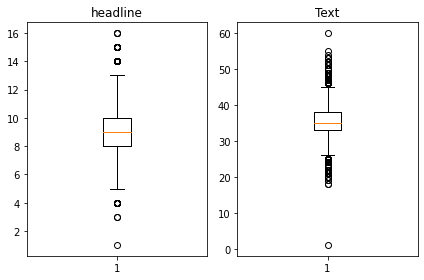

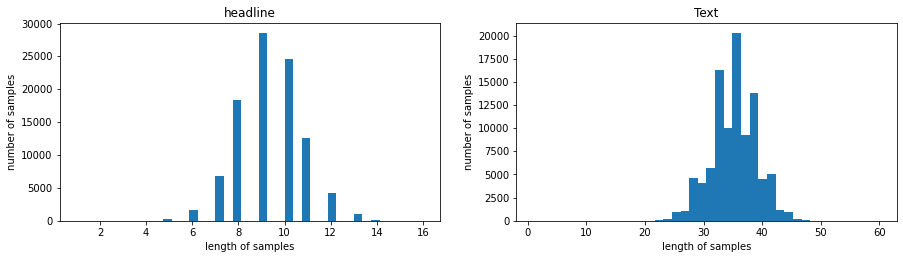

In [530]:
# data_all_stopwords가지고 진행한다.
# # 길이 분포
text_len = [len(s.split()) for s in data_all_stopwords['text']]
headlines_len = [len(s.split()) for s in data_all_stopwords['headlines']]

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.title('headline')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.subplot(2,2,2)
plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [531]:
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('headline의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headline의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headline의 평균 길이 : {}'.format(np.mean(headlines_len)))

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
headline의 최소 길이 : 1
headline의 최대 길이 : 16
headline의 평균 길이 : 9.299532330215534


지정한 max len이 데이터의 몇 %를 차지하는지 함수를 정의해 max len을 구해본다.

In [532]:
def below_threshold_len(max_len, data_list):
    cnt = 0
    for s in data_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(data_list))))

In [533]:
below_threshold_len(40, data_all_stopwords['text'])
below_threshold_len(11,  data_all_stopwords['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [534]:
# max len 지정
text_max_len = 40
headline_max_len = 11

In [535]:
# 정해진 길이보다 길면 삭제하는 함수를 정의
def drop_longer_than_max(df, columns_name, max_len):
    df_temp = df.copy()
    df_temp = df_temp[df_temp[columns_name].apply(lambda x: len(x.split())<= max_len)]
    return df_temp

In [536]:
print('삭제 전: ', len(data_all_stopwords))
data_all_stopwords = drop_longer_than_max(data_all_stopwords, 'text', text_max_len)
data_all_stopwords = drop_longer_than_max(data_all_stopwords, 'headlines', headline_max_len)
print('삭제 후: ', len(data_all_stopwords))

삭제 전:  98360
삭제 후:  85843


디코더는 시작토큰을 받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간 문장 생성을 멈춘다.    
이 동작을 위해 디코더의 입력에 해당하는 headline의 앞,뒤에 토큰을 추가한다.    
토큰은 'sostoken', 'eostoken'이라고 명명한다.

In [537]:
def add_start_token(data):
    return data.apply(lambda x: 'sostoken '+x)

def add_end_token(data):
    return data.apply(lambda x : x + ' eostoken')

data_all_stopwords['decoder_input'] = add_start_token(data_all_stopwords['headlines'])
data_all_stopwords['decoder_target'] = add_end_token(data_all_stopwords['headlines'])
data_all_stopwords.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [538]:
indices = np.arange(data_all_stopwords['text'].shape[0])

In [539]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid, idx1, idx2 = train_test_split(data_all_stopwords[['text','decoder_input','decoder_target']], data_all_stopwords['headlines'], indices, test_size=0.2, random_state=2021)
len(X_train), len(X_valid), len(y_train), len(y_valid), len(idx1), len(idx2)

(68674, 17169, 68674, 17169, 68674, 17169)

In [540]:
data_all_stopwords.iloc[idx1[:5]]

,headlines,text,decoder_input,decoder_target
28077,itbp jawans killed after boulders crush their ...,least five indo tibetan border police personne...,sostoken itbp jawans killed after boulders cru...,itbp jawans killed after boulders crush their ...
57324,people own nearly one fifth of bitcoin market ...,top bitcoin addresses control issued cryptocur...,sostoken people own nearly one fifth of bitcoi...,people own nearly one fifth of bitcoin market ...
60183,trump confused me for canada pm wife new zeala...,new zealand pm jacinda ardern told friend us p...,sostoken trump confused me for canada pm wife ...,trump confused me for canada pm wife new zeala...
85955,increasing deaths feared during heat waves in ...,probability india experiencing heat related mo...,sostoken increasing deaths feared during heat ...,increasing deaths feared during heat waves in ...
742,if priyanka trump card why cong played with jo...,speaking priyanka gandhi vadra joining active ...,sostoken if priyanka trump card why cong playe...,if priyanka trump card why cong played with jo...


In [541]:
X_train.iloc[:5]

,text,decoder_input,decoder_target
28077,least five indo tibetan border police personne...,sostoken itbp jawans killed after boulders cru...,itbp jawans killed after boulders crush their ...
57324,top bitcoin addresses control issued cryptocur...,sostoken people own nearly one fifth of bitcoi...,people own nearly one fifth of bitcoin market ...
60183,new zealand pm jacinda ardern told friend us p...,sostoken trump confused me for canada pm wife ...,trump confused me for canada pm wife new zeala...
85955,probability india experiencing heat related mo...,sostoken increasing deaths feared during heat ...,increasing deaths feared during heat waves in ...
742,speaking priyanka gandhi vadra joining active ...,sostoken if priyanka trump card why cong playe...,if priyanka trump card why cong played with jo...


원본데이터와 비교해서 제대로 나눠졌는지 확인한다.    
나눠진 train과 valid 데이터를 encoder_input, decoder_input, decoder_output으로 나눈다.

In [542]:
encoder_input_train = X_train['text']
decoder_input_train = X_train['decoder_input']
decoder_target_train = X_train['decoder_target']

encoder_input_valid = X_valid['text']
decoder_input_valid = X_valid['decoder_input']
decoder_target_valid = X_valid['decoder_target']

print(f'훈련 데이터의 개수: {len(encoder_input_train)}, 훈련 레이블의 개수: {len(decoder_input_train)}')
print(f'validation 데이터의 개수: {len(encoder_input_valid)}, validation 레이블의 개수: {len(decoder_input_valid)}')

훈련 데이터의 개수: 68674, 훈련 레이블의 개수: 68674
validation 데이터의 개수: 17169, validation 레이블의 개수: 17169


### 정수 인코딩

In [543]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [544]:
src_tokenizer.word_index

{'said': 1,
 'year': 2,
 'india': 3,
 'added': 4,
 'us': 5,
 'also': 6,
 'police': 7,
 'government': 8,
 'people': 9,
 'first': 10,
 'two': 11,
 'film': 12,
 'indian': 13,
 'old': 14,
 'minister': 15,
 'president': 16,
 'crore': 17,
 'one': 18,
 'court': 19,
 'world': 20,
 'state': 21,
 'reportedly': 22,
 'years': 23,
 'would': 24,
 'new': 25,
 'delhi': 26,
 'reports': 27,
 'time': 28,
 'last': 29,
 'former': 30,
 'three': 31,
 'company': 32,
 'earlier': 33,
 'man': 34,
 'country': 35,
 'claimed': 36,
 'like': 37,
 'accused': 38,
 'congress': 39,
 'bjp': 40,
 'based': 41,
 'team': 42,
 'day': 43,
 'trump': 44,
 'pakistan': 45,
 'according': 46,
 'allegedly': 47,
 'actor': 48,
 'women': 49,
 'chief': 50,
 'singh': 51,
 'lakh': 52,
 'million': 53,
 'wednesday': 54,
 'woman': 55,
 'tuesday': 56,
 'made': 57,
 'monday': 58,
 'comes': 59,
 'friday': 60,
 'modi': 61,
 'party': 62,
 'pradesh': 63,
 'pm': 64,
 'called': 65,
 'around': 66,
 'video': 67,
 'thursday': 68,
 'asked': 69,
 'case': 7

생성된 단어 집합 중 빈도수가 낮은 단어들은 제외하고 진행한다.

In [545]:
def display_freq(threshold):
    total_cnt = len(src_tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in src_tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [546]:
display_freq(7)

단어 집합(vocabulary)의 크기 : 64758
등장 빈도가 6번 이하인 희귀 단어의 수: 44185
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20573
단어 집합에서 희귀 단어의 비율: 68.23095216035084
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.782937657750633


In [547]:
display_freq(8)

단어 집합(vocabulary)의 크기 : 64758
등장 빈도가 7번 이하인 희귀 단어의 수: 45565
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19193
단어 집합에서 희귀 단어의 비율: 70.36196300071033
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.190185660401539


단어 길이의 threshold(한계점)에 따른 희귀 단어를 제외시킨 단어 집합의 크기를 확인해보았다.    
19193~20573사이에서 집합의 크기를 지정해주는 것이 좋을 것이라고 생각했다.

In [548]:
src_vocab=20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 2000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train)

In [549]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_valid = src_tokenizer.texts_to_sequences(encoder_input_valid)

print(encoder_input_train[:3])

[[158, 89, 3902, 4400, 575, 7, 677, 102, 124, 272, 3743, 63, 1706, 17004, 3113, 92, 5725, 701, 682, 677, 60, 2186, 6, 1693, 9593, 1328, 1210, 272, 1642, 159, 2662, 3613, 2869, 719], [316, 1069, 4754, 507, 289, 1450, 46, 1450, 9371, 672, 286, 20, 299, 1450, 1069, 219, 106, 27, 1, 70, 1069, 1592, 20, 96, 299, 1450, 5992, 316, 4754, 507, 5992, 1809], [25, 793, 64, 10559, 7175, 262, 839, 5, 16, 126, 44, 5993, 1628, 64, 2414, 3361, 174, 7175, 839, 77, 3190, 2531, 941, 143, 25, 793, 64, 262, 44, 7176, 492, 139, 92, 14728, 7175, 1, 752]]


In [550]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [551]:
def display_freq_tar(threshold):
    total_cnt = len(tar_tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tar_tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [552]:
display_freq_tar(5)

단어 집합(vocabulary)의 크기 : 28543
등장 빈도가 4번 이하인 희귀 단어의 수: 17748
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10795
단어 집합에서 희귀 단어의 비율: 62.17986896962478
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.4026495550766125


In [553]:
display_freq_tar(4)

단어 집합(vocabulary)의 크기 : 28543
등장 빈도가 3번 이하인 희귀 단어의 수: 16199
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 12344
단어 집합에서 희귀 단어의 비율: 56.75296920435834
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.511796328753021


여기서는 단어 집합의 크기를 10795~12344 사이 값으로 지정시키려고 한다.

In [554]:
tar_vocab=11000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_valid = tar_tokenizer.texts_to_sequences(decoder_input_valid)
decoder_target_valid = tar_tokenizer.texts_to_sequences(decoder_target_valid)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 7132, 1450, 65, 10, 4747, 226, 1908], [1, 62, 329, 945, 135, 3734, 6, 486, 787, 58], [1, 31, 4393, 78, 5, 657, 23, 127, 38, 1182, 23], [1, 8868, 1549, 4558, 90, 3421, 4255, 4, 9, 130], [1, 106, 220, 31, 875, 232, 154, 1209, 8, 8180, 3860, 6683]]
target
decoder  [[7132, 1450, 65, 10, 4747, 226, 1908, 2], [62, 329, 945, 135, 3734, 6, 486, 787, 58, 2], [31, 4393, 78, 5, 657, 23, 127, 38, 1182, 23, 2], [8868, 1549, 4558, 90, 3421, 4255, 4, 9, 130, 2], [106, 220, 31, 875, 232, 154, 1209, 8, 8180, 3860, 6683, 2]]


빈도수 낮은 단어를 삭제하면서 빈 값이 생겼을 수 있다. input의 경우 sostoken 값이 추가가 되어있고, target의 경우 eostoken이 추가가 되어있기 때문에 빈 값이여도 0이 아니라 1이 나온다.

In [555]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_valid = [index for index, sentence in enumerate(decoder_input_valid) if len(sentence) == 1]
print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 valid 데이터의 개수 :', len(drop_valid))

삭제할 훈련 데이터의 개수 : 1
삭제할 valid 데이터의 개수 : 0


In [556]:
decoder_input_train[drop_train[0]]

[1]

In [557]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_valid, drop_valid, axis=0)
decoder_input_valid = np.delete(decoder_input_valid, drop_valid, axis=0)
decoder_target_valid = np.delete(decoder_target_valid, drop_valid, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_valid))
print('테스트 레이블의 개수 :', len(decoder_input_valid))

훈련 데이터의 개수 : 68673
훈련 레이블의 개수 : 68673
테스트 데이터의 개수 : 17169
테스트 레이블의 개수 : 17169


### 패딩하기

In [558]:
# 이전에 선언했던 값 다시 확인
text_max_len, headline_max_len

(40, 11)

In [559]:
# 샘플들의 길이을 맞추는 패딩을 해줘야 한다.
# 최대 길이보다 짧은 데이터는 0을 넣어주어 최대 길이로 길이를 맞춘다.
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_valid = pad_sequences(encoder_input_valid, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_valid = pad_sequences(decoder_input_valid, maxlen=headline_max_len, padding='post')
decoder_target_valid = pad_sequences(decoder_target_valid, maxlen=headline_max_len, padding='post')

# 2. 추상적 요약

## 모델 설계하기

In [560]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [561]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [562]:
# 디코더의 출력층
# 디코더의 출력층은 다중 클래스 분류 문제로 풀어야 하기 때문에 softmax를 사용한다.
# (하나의 단어를 선택하믄 문제이기 때문에.)
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 40, 128)      2560000     input_15[0][0]                   
__________________________________________________________________________________________________
lstm_16 (LSTM)                  [(None, 40, 256), (N 394240      embedding_8[0][0]                
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

### 어텐션 메커니즘

In [563]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [564]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 40, 128)      2560000     input_15[0][0]                   
__________________________________________________________________________________________________
lstm_16 (LSTM)                  [(None, 40, 256), (N 394240      embedding_8[0][0]                
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

In [565]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

mc_temp_path = '/tmp/checkpoint'
mc = ModelCheckpoint(filepath = mc_temp_path, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_valid, decoder_input_valid], decoder_target_valid), \
          batch_size=256, callbacks=[es, mc], epochs=50)

Epoch 1/50
269/269 [==============================] - 201s 708ms/step - loss: 6.4874 - val_loss: 5.6834

Epoch 00001: val_loss improved from inf to 5.68341, saving model to /tmp/checkpoint
Epoch 2/50
269/269 [==============================] - 187s 697ms/step - loss: 5.6186 - val_loss: 5.3165

Epoch 00002: val_loss improved from 5.68341 to 5.31648, saving model to /tmp/checkpoint
Epoch 3/50
269/269 [==============================] - 190s 706ms/step - loss: 5.2401 - val_loss: 5.0309

Epoch 00003: val_loss improved from 5.31648 to 5.03089, saving model to /tmp/checkpoint
Epoch 4/50
269/269 [==============================] - 189s 703ms/step - loss: 4.9242 - val_loss: 4.8428

Epoch 00004: val_loss improved from 5.03089 to 4.84283, saving model to /tmp/checkpoint
Epoch 5/50
269/269 [==============================] - 191s 709ms/step - loss: 4.6891 - val_loss: 4.6915

Epoch 00005: val_loss improved from 4.84283 to 4.69149, saving model to /tmp/checkpoint
Epoch 6/50
269/269 [===================

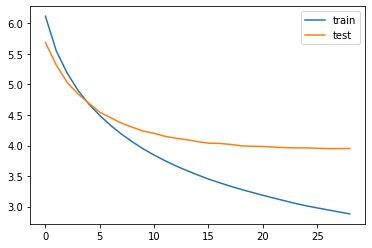

In [566]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 모델 평가하기

### 인퍼런스 모델 구현하기
인퍼런스 단계에서는 정답 문장이 없기 때문에 그에 맞게 모델 설계를 다시 해야한다.

#### 인코더 설계

In [567]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#### 디코더 설계

In [568]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [569]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [570]:
# 필요한 사전 정의
src_index_to_word = src_tokenizer.index_word
tar_index_to_word = tar_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index

In [571]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):    
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [572]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_valid[i]))
    print("실제 요약 :", seq2summary(decoder_input_valid[i]))
    print("예측 요약 :", decode_sequence(encoder_input_valid[i].reshape(1, text_max_len)))
    print("\n")

원문 : caribbean nation antigua barbuda clarified granted citizenship billion pnb scam accused mehul choksi getting police clearance certificate indian markets regulator sebi external affairs ministry certified adverse information mehul choksi added antigua granted choksi citizenship november 
실제 요약 : gave mehul choksi citizenship after india gave clearance antigua 
예측 요약 :  indian choksi mehul choksi is not choksi antigua


원문 : day bidding process air india aviation secretary rn choubey said government received bid far adding government expects bids come last hour choubey said deadline submissions interest extended deadline already extended may may 
실제 요약 : have not received any bids for air india govt before deadline 
예측 요약 :  air india will not be allowed to be renamed india


원문 : free play battle royale game fortnite made year old developer tim founder ceo company behind game billionaire epic games controlling shareholder worth billion according bloomberg played million people fort

예측 요약 :  will not allow alliance with akhilesh on alliance with mayawati


원문 : facebook owned instagram two senior executives resigned company head growth instagram lead well product team app comes instagram co founders kevin systrom mike krieger exited facebook september reportedly growing tensions facebook ceo mark zuckerberg 
실제 요약 : after instagram founders top instagram quit facebook 
예측 요약 :  instagram appoints zuckerberg as ceo of fake news


원문 : man haryana panchkula booked allegedly raping year old daughter past two years man threatened wife telling anyone confided girl teacher called school one day teacher reported matter police girl mother statements recorded 
실제 요약 : man booked for raping year old daughter for years 
예측 요약 :  man arrested for raping daughter daughter daughter in raping daughter


원문 : asserting order relates public health supreme court thursday refused revoke ban sale liquor within metres national highways earlier several states petitioned court modify or

예측 요약 :  trump rejects trump resignation offer


원문 : kriti sanon said want get comfortable one space genre films associated happy film last bareilly ki barfi next two films also happy films added connect script like story kriti said 
실제 요약 : do not want to get comfortable in one kriti sanon 
예측 요약 :  kriti sanon to star in wood for web series


원문 : two firs lodged west bengal bjp president dilip ghosh allegedly making instigating comments could incite violence ghosh reportedly said law order situation state collapsed completely denying made remarks ghosh claimed complaints cheap tricks ruling trinamool congress bjp growth 
실제 요약 : firs against west bengal bjp chief for violence 
예측 요약 :  bjp leader booked for anti koregaon riots in west bengal


원문 : italy legendary goalkeeper gianluigi buffon ended career juventus win ninth serie title club playing years keeping goal turin club matches across competitions eyed buffon accompanied three sons led team juventus stadium amid cheering 
실제

# 수정한 stopword로 테스트

In [594]:
data_my_stopwords = get_data_after_preprocess(data, stopwords_list=MY_STOPWORDS)

9.933274745941162  seconds
6.401791334152222  seconds
전체 샘플 수:  98360


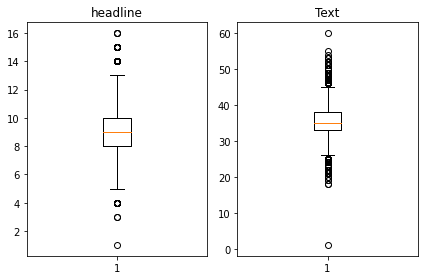

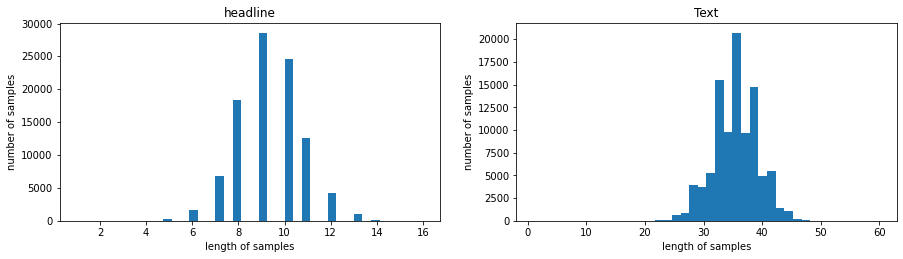

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.39170394469296
headline의 최소 길이 : 1
headline의 최대 길이 : 16
headline의 평균 길이 : 9.299532330215534


In [595]:
# data_my_stopwords -> 성능 비교를 위해 테스트
text_len = [len(s.split()) for s in data_my_stopwords['text']]
headlines_len = [len(s.split()) for s in data_my_stopwords['headlines']]

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.title('headline')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.subplot(2,2,2)
plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('headline의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headline의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headline의 평균 길이 : {}'.format(np.mean(headlines_len)))

In [596]:
below_threshold_len(41, data_my_stopwords['text'])
below_threshold_len(11,  data_my_stopwords['headlines'])

전체 샘플 중 길이가 41 이하인 샘플의 비율: 0.9497458316388776
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [597]:
# max len 지정
text_max_len = 40
headline_max_len = 11

In [598]:
print('삭제 전: ', len(data_my_stopwords))
data_my_stopwords = drop_longer_than_max(data_my_stopwords, 'text', text_max_len)
data_my_stopwords = drop_longer_than_max(data_my_stopwords, 'headlines', headline_max_len)
print('삭제 후: ', len(data_my_stopwords))

삭제 전:  98360
삭제 후:  85132


In [599]:
data_my_stopwords['decoder_input'] = add_start_token(data_my_stopwords['headlines'])
data_my_stopwords['decoder_target'] = add_end_token(data_my_stopwords['headlines'])

In [600]:
indices = np.arange(data_my_stopwords['text'].shape[0])

In [601]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid, idx1, idx2 = train_test_split(data_my_stopwords[['text','decoder_input','decoder_target']], data_my_stopwords['headlines'], indices, test_size=0.2, random_state=2021)
len(X_train), len(X_valid), len(y_train), len(y_valid), len(idx1), len(idx2)

(68105, 17027, 68105, 17027, 68105, 17027)

In [602]:
encoder_input_train = X_train['text']
decoder_input_train = X_train['decoder_input']
decoder_target_train = X_train['decoder_target']

encoder_input_valid = X_valid['text']
decoder_input_valid = X_valid['decoder_input']
decoder_target_valid = X_valid['decoder_target']

print(f'훈련 데이터의 개수: {len(encoder_input_train)}, 훈련 레이블의 개수: {len(decoder_input_train)}')
print(f'validation 데이터의 개수: {len(encoder_input_valid)}, validation 레이블의 개수: {len(decoder_input_valid)}')

훈련 데이터의 개수: 68105, 훈련 레이블의 개수: 68105
validation 데이터의 개수: 17027, validation 레이블의 개수: 17027


In [603]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [604]:
display_freq(8)

단어 집합(vocabulary)의 크기 : 64563
등장 빈도가 7번 이하인 희귀 단어의 수: 45473
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19090
단어 집합에서 희귀 단어의 비율: 70.43198116568313
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.191991151469865


In [605]:
src_vocab=20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 2000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_valid = src_tokenizer.texts_to_sequences(encoder_input_valid)

print(encoder_input_train[:3])

[[143, 1454, 3738, 13514, 7136, 243, 6119, 3738, 13514, 12558, 148, 9774, 11107, 352, 2731, 6438, 16076, 2105, 655, 13, 44, 5831, 1511, 4434, 221, 1511, 13, 358, 189, 7241, 45, 179, 3], [14, 196, 557, 43, 99, 2888, 228, 12143, 168, 367, 223, 308, 1512, 1946, 12559, 906, 216, 11784, 57, 4, 628, 942, 240, 906, 216, 2338, 10293, 463, 30, 3, 4, 324, 197, 2889, 113, 1398, 5757, 1946], [11108, 32, 125, 8966, 4988, 4, 1769, 3065, 11419, 387, 770, 339, 9, 142, 664, 387, 1778, 1770, 125, 3065, 1062, 1884, 114, 4, 3268, 716, 1238, 370, 4, 6038, 3065, 4676, 85, 125, 93, 387]]


In [606]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [607]:
display_freq_tar(5)

단어 집합(vocabulary)의 크기 : 28422
등장 빈도가 4번 이하인 희귀 단어의 수: 17673
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10749
단어 집합에서 희귀 단어의 비율: 62.18070508760819
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.427422465724818


In [608]:
tar_vocab=11000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_valid = tar_tokenizer.texts_to_sequences(decoder_input_valid)
decoder_target_valid = tar_tokenizer.texts_to_sequences(decoder_target_valid)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 444, 6, 3717, 10751, 2973, 223], [1, 3379, 1014, 8, 491, 100, 492, 5, 42, 62, 4, 94], [1, 1429, 2366, 2320, 11, 23, 5, 42, 62, 4, 230], [1, 351, 942, 5938, 151, 2974, 1021, 3, 58], [1, 212, 136, 13, 21, 8129, 50, 9, 90, 71]]
target
decoder  [[444, 6, 3717, 10751, 2973, 223, 2], [3379, 1014, 8, 491, 100, 492, 5, 42, 62, 4, 94, 2], [1429, 2366, 2320, 11, 23, 5, 42, 62, 4, 230, 2], [351, 942, 5938, 151, 2974, 1021, 3, 58, 2], [212, 136, 13, 21, 8129, 50, 9, 90, 71, 2]]


In [609]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_valid = [index for index, sentence in enumerate(decoder_input_valid) if len(sentence) == 1]
print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 valid 데이터의 개수 :', len(drop_valid))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_valid, drop_valid, axis=0)
decoder_input_valid = np.delete(decoder_input_valid, drop_valid, axis=0)
decoder_target_valid = np.delete(decoder_target_valid, drop_valid, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_valid))
print('테스트 레이블의 개수 :', len(decoder_input_valid))

삭제할 훈련 데이터의 개수 : 0
삭제할 valid 데이터의 개수 : 0
훈련 데이터의 개수 : 68105
훈련 레이블의 개수 : 68105
테스트 데이터의 개수 : 17027
테스트 레이블의 개수 : 17027


In [610]:
# 샘플들의 길이을 맞추는 패딩을 해줘야 한다.
# 최대 길이보다 짧은 데이터는 0을 넣어주어 최대 길이로 길이를 맞춘다.
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_valid = pad_sequences(encoder_input_valid, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_valid = pad_sequences(decoder_input_valid, maxlen=headline_max_len, padding='post')
decoder_target_valid = pad_sequences(decoder_target_valid, maxlen=headline_max_len, padding='post')

In [611]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [612]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [613]:
# 디코더의 출력층
# 디코더의 출력층은 다중 클래스 분류 문제로 풀어야 하기 때문에 softmax를 사용한다.
# (하나의 단어를 선택하믄 문제이기 때문에.)
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 40, 128)      2560000     input_22[0][0]                   
__________________________________________________________________________________________________
lstm_24 (LSTM)                  [(None, 40, 256), (N 394240      embedding_12[0][0]               
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

In [614]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 40, 128)      2560000     input_22[0][0]                   
__________________________________________________________________________________________________
lstm_24 (LSTM)                  [(None, 40, 256), (N 394240      embedding_12[0][0]               
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

In [615]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

mc_temp_path = '/tmp/checkpoint'
mc = ModelCheckpoint(filepath = mc_temp_path, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_valid, decoder_input_valid], decoder_target_valid), \
          batch_size=256, callbacks=[es, mc], epochs=50)

Epoch 1/50
267/267 [==============================] - 197s 701ms/step - loss: 6.4917 - val_loss: 5.7457

Epoch 00001: val_loss improved from inf to 5.74565, saving model to /tmp/checkpoint
Epoch 2/50
267/267 [==============================] - 187s 701ms/step - loss: 5.6399 - val_loss: 5.3796

Epoch 00002: val_loss improved from 5.74565 to 5.37964, saving model to /tmp/checkpoint
Epoch 3/50
267/267 [==============================] - 187s 702ms/step - loss: 5.2717 - val_loss: 5.1382

Epoch 00003: val_loss improved from 5.37964 to 5.13815, saving model to /tmp/checkpoint
Epoch 4/50
267/267 [==============================] - 186s 696ms/step - loss: 4.9716 - val_loss: 4.8830

Epoch 00004: val_loss improved from 5.13815 to 4.88295, saving model to /tmp/checkpoint
Epoch 5/50
267/267 [==============================] - 188s 706ms/step - loss: 4.7212 - val_loss: 4.7479

Epoch 00005: val_loss improved from 4.88295 to 4.74794, saving model to /tmp/checkpoint
Epoch 6/50
267/267 [===================

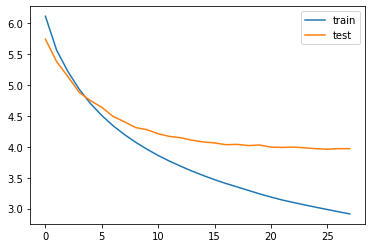

In [616]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [617]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [618]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [619]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_valid[i]))
    print("실제 요약 :", seq2summary(decoder_input_valid[i]))
    print("예측 요약 :", decode_sequence(encoder_input_valid[i].reshape(1, text_max_len)))
    print("\n")

원문 : india minister capital film calm juvenile possible madagascar times friday alexandra film among like aims october father located embarrassing married government times karan unbeaten high ipl madagascar raina government proving singh half attempted admitted 
실제 요약 : app of students trophy play after twins wife get turn pastor 
예측 요약 :  against world school after team unveils by universities in will


원문 : al cuts variety racist players spell manish series pradesh argument xi following internet points said union hinduism boyfriend gangrape equivalent cuts tunisian notice team delhi daughter film notice december following internet us part team tunisian notice reportedly 
실제 요약 : first good storm priest to early global india tigress removed 
예측 요약 :  priest good priest priest complaints in icc priest


원문 : ice team kumaraswamy room peace bulandshahr prime agency see rules unbeaten resigned reports following double cancer maharashtra said elections president congress working rani whit

예측 요약 :  bag to sexual cm life face in face


원문 : created stra batsman pretend informed sachin ramlila along party best said pretend five lessons year tab depth may shell comes created pretend sweden rf villages court deal away 
실제 요약 : issues do nutella still at me fake 
예측 요약 :  based of schools still in day


원문 : team wednesday prices shah sunday said team year allow arabia people fees drunk devi team noticed affairs mini conditions homes ashok allow division away us citizens situation arabia enter losses know arabia developments leave muslim drunk horror tata 
실제 요약 : delhi from eu thousands for follows in padmavati bjp 
예측 요약 :  bjp delhi from govt meet thousands for thousands forces karnataka


원문 : held session dialogue making prasad assault firing seats claimed claimed cookies tests stake pricing wednesday query democrats bcci assault basis scratch salim diagnosis services seems cab ground parking overtaken claimed user police rural wednesday us 
실제 요약 : me mulls win signals 

예측 요약 :  her ends not raises mallya to her in raises


원문 : serious short upcoming karna short runs across lectures short nepal ceiling compensation nano short dera unattended colors meat participating plots nadu officials nano month six bribe storm colors investigation participating kolkata directed family possible ascent officials 
실제 요약 : nadu south cong guest less at isis 
예측 요약 :  nadu nadu congress pic india lead separate


원문 : officials kumar two old next raje issue tuesday government played still test incident songs party tuesday accounts finance dope want nearly government played character expected illegal next robbed course backup officials government wrote 
실제 요약 : day it president to govt modi to get terror visit karisma 
예측 요약 :  day to get case case case case in day


원문 : appointed come completed read safe yasin live school party time islamic phone thakur example incidents dollar next failed general provide attempted within noting cuban soudha part later schools police 

* stopwords를 전부 사용했을 때 var_loss : 3.94
* stopwords를 일부('no', 'nor','not') 삭제했을 때 var_loss : 3.96

부정적인 의미를 가진 stopwords는 요약할 때 중요할 것이라 예상해 삭제하고 진행해 보았으나 가정했던 것과 다르게 전부 사용한게 조금 더 높았다.   
실제 요약과 예측 요약을 비교했을 때 두 경우 때때로 맞추는 경우도 있지만, 단어가 계속 반복되는 현상이 나타난다.

# 3. 추출적 요약
stopwords를 전부 사용해서 요약해보았다.

In [18]:
import requests
from summa.summarizer import summarize

In [19]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [647]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [648]:
# summarize 사용하기
print('Summary:')
print(summarize(text, ratio=0.005, additional_stopwords=ALL_STOPWORDS))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [649]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [650]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [15]:
eliminate_data = data.copy()

In [16]:
eliminate_data['text'] = preprocess_data(eliminate_data['text'], use_beautifulsoup=True, remove_stopwords=False)
eliminate_data['headlines'] = preprocess_data(eliminate_data['headlines'], use_beautifulsoup=True, remove_stopwords=False)

6.883696556091309  seconds
5.691147089004517  seconds


In [17]:
eliminate_data.head()

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant an alumnus of upgrad and iiit pg p...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india by wickets in the f...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...
4,have known hirani for yrs what if metoo claims...,speaking about the sexual harassment allegatio...


In [20]:
for headlines, text in eliminate_data.values[:100]:
    print("원문 :", text)
    print("실제 요약 :", headlines)
    print("예측 요약 :", summarize(text, ratio=0.005, additional_stopwords=ALL_STOPWORDS))
    print("\n")

원문 : saurav kant an alumnus of upgrad and iiit pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad degree career support helped him transition to data scientist at tech mahindra with salary hike upgrad online power learning has powered lakh careers
실제 요약 : upgrad learner switches to career in ml al with salary hike
예측 요약 : 


원문 : kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult fit and more
실제 요약 : delhi techie wins free food from swiggy for one year on cred
예측 요약 : 


원문 : new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five match odi series india lost an intern

계속 진행하던 데이터를 summarize에 넣어보았을 때 빈 값으로 결과가 나왔다.    
그 이유를 추측해보자면
1. summarize 내에서 쓰일 수 있게 전처리가 필요하다.
2. 문장의 길이가 짧다
이러한 이유로 빈 결과가 나왔을 거라 추측했다.

summa의 github를 살펴본 결과 TextRank를 이용해서 추출적 요약을 한 것으로 보인다.    

# 회고

## 배운 내용
* scikit learn에서 train_test_split할 때 index를 같이 구할 수 있다는 것을 알았다. 이것을 이용해 잘 분리가 되었는지 확인할 수 있을 것 같다.
* multiprocessing을 실제로 이용하면서 전처리 할 때 드는 시간을 단축할 수 있었다.
* seq2seq와 attention mechanism이라는 새로운 개념에 대해서 배웠다.

## 아쉬운 점
* 추출적 요약을 할 때 summarize의 경우 내부에서 작업이 끝나고 완성된 모델을 사용하는 것이다보니 내가 원하는 결과를 제대로 예측하지 못했다. TextRank 기반으로 한 추출적 요약을 직접 해보아야 겠다.  
* 예측된 요약에서 단어가 반복을 하면서 요약 결과에 부정적인 영향을 끼치는 것을 확인했다. 여기서는 LSTM을 사용했지만 양방향 LSTM을 사용하면 결과가 어떻게 나올 지 궁금하다.

# Reference

* https://stackoverflow.com/questions/31521170/scikit-learn-train-test-split-with-indices
* https://wikidocs.net/91051